In [2]:
# Importing dependencies
import numpy as np
import pandas
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import math
import seaborn as sns
from sqlalchemy import create_engine
from password import password

In [3]:
protocol = 'postgresql'
username = 'postgres'
password = password
host = 'localhost'
port = 5432
database_name = 'churn_pred'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
connection = engine.connect()

In [4]:
# Loading and displaying a dataset
df = pd.read_sql("SELECT * FROM fact_churn", connection)
df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,international_plan_yes,voice_mail_plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0,1
1,118,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0,1,0
2,62,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,0,0,0
3,93,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,1,0,0
4,174,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,1,0,0


In [5]:
# Split the data into X_train, X_test, y_train, y_test
X = df.drop(['churn'], axis=1)
y = df['churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.25)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Checking data split in training
X_train.shape

(3750, 17)

In [7]:
# Checking data split in testing
X_test.shape

(1250, 17)

In [8]:
# Retrieving sample of the data
X.sample(5)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_yes,voice_mail_plan_yes
2247,68,0,157.3,83,26.74,220.9,85,18.78,218.9,129,9.85,12.0,7,3.24,1,0,0
2786,127,0,247.5,99,42.08,108.5,118,9.22,232.0,72,10.44,10.6,3,2.86,2,1,0
215,1,30,183.1,95,31.13,232.6,110,19.77,248.3,110,11.17,8.4,2,2.27,0,0,1
3132,146,0,115.6,77,19.65,213.6,100,18.16,218.4,72,9.83,10.7,6,2.89,1,0,0
2432,101,16,118.9,112,20.21,228.3,97,19.41,180.1,111,8.10,8.2,5,2.21,2,0,1


In [15]:
# Tuning Hyper-parameter
rfc = RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42, class_weight='balanced')

In [35]:
# Testing the optimised model
rfc.fit(X_train_scaled, y_train)
thresh = 0.33
pt = np.where(rfc.predict_proba(X_test_scaled)[:,1] > thresh, 1, 0)
print(f"Training Data Score: {rfc.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rfc.score(X_test_scaled, y_test)}")

Training Data Score: 0.948
Testing Data Score: 0.8816


In [36]:
# Creating a confusion matrix
y_pred = rfc.predict(X_test_scaled)
confusion_matrix = metrics.confusion_matrix(y_test, pt)
confusion_matrix

array([[905, 108],
       [ 91, 146]])

Text(0.5, 257.44, 'Predicted label')

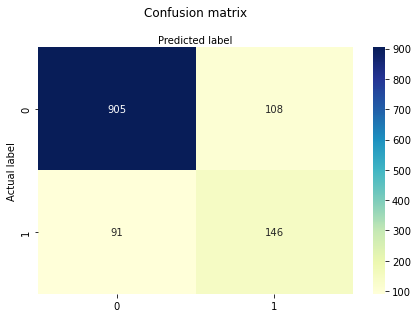

In [30]:
# Creating confusion matrix diagram
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create a heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
# Create the classification report
target_names = ['churn: no', 'churn: yes']
print(classification_report(y_test, pt, target_names=target_names))

              precision    recall  f1-score   support

   churn: no       0.91      0.89      0.90      1013
  churn: yes       0.57      0.62      0.59       237

    accuracy                           0.84      1250
   macro avg       0.74      0.75      0.75      1250
weighted avg       0.85      0.84      0.84      1250



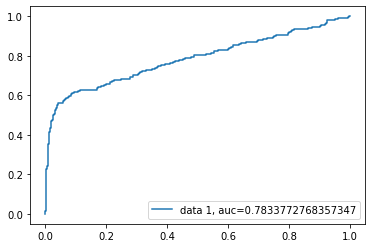

In [32]:
# Create area under the curve graph
y_pred_proba = rfc.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr,label='data 1, auc=' + str(auc))
plt.legend(loc=4)
plt.show()